In [1]:
from datasets import SOCOFingGender, SOCOFingFingers, SOCOFingSubjects
from FPMLmodule.backbones import ResNet50
from FPMLmodule.classifiers import ResNetClassifier
from FPMLmodule.fpml import FPML 
from FPMLmodule.utils import displayDsSamples, displayDsSplit, displayTrainProgress, displayConfusion
import numpy as np
from matplotlib import pyplot as plt
# from keras import layers, Sequential, models
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.0


In [2]:
# Global Config
seed=9
img_dim = (120, 120, 3)
img_height, img_width, img_channels = img_dim
batch_size = 32

# Dataset configuration

AUTOTUNE = tf.data.AUTOTUNE
split_ratio = [0.7, 0.15, 0.15]
shuffle=True
dsConfig = {
    'batchSize': batch_size, 
    'parallelTune': AUTOTUNE, 
    'split': split_ratio, 
    'inputDim': img_dim, 
    'seed': seed, 
    'shuffle': shuffle
    }
weights = "./weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Model Config
learning_rate = 0.001
epochs_find_best = 10
epochs_best = 100



print(img_dim)
print(img_height, img_width, img_channels)

genderClassNames=['F','M']
fingersClassNames=['R_thumb', 'R_index', 'R_middle', 'R_ring', 'R_little', 'L_thumb', 'L_index', 'L_middle', 'L_ring', 'L_little ']

(120, 120, 3)
120 120 3


In [3]:
SOCOGender = SOCOFingGender(**dict(dsConfig, sampling=SOCOFingGender.UNDER_SAMPLING))
SOCOSubjects = SOCOFingSubjects(**dsConfig)
SOCOFingers = SOCOFingFingers(**dsConfig)

genderDS = SOCOGender.create()
subjectDS = SOCOSubjects.create()
fingersDS = SOCOFingers.create()

Metal device set to: AMD Radeon Pro 5500M

systemMemory: 16.00 GB
maxCacheSize: 1.99 GB



2022-05-02 20:35:06.496856: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-02 20:35:06.497655: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-02 20:35:06.497945: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Dataset split check

In [4]:
dsNames = ['SOCOGender  ', 'SOCOSubjects', 'SOCOFingers ']
splitNames = ['train', 'test ', 'valid']
datasets = [genderDS, subjectDS, fingersDS]

data = []
for ds in datasets:
    splitLens = []
    for split in ds:
        splitLen = 0
        for _, labels in split.as_numpy_iterator():
            splitLen+=len(labels)
        splitLens.append(splitLen)
    data.append(splitLens)

print((" "*45)+"Datasets split")
row_format ="{:>15}" * (len(dsNames) + 2)
print(row_format.format("", *splitNames, 'total'))
for name, row in zip(dsNames, data):
    print(row_format.format(name, *row, np.sum(row)))


print("\n"+(" "*45)+"Dataset Check")
unionSet = set()
interSet = set()
sets = []
for ds in subjectDS:
    dsSet = set()
    for _, labels in ds.as_numpy_iterator():
        for label in labels:
            parseLabel = label.decode('utf-8')
            dsSet.add(parseLabel)
    sets.append(dsSet)
    unionSet = unionSet.union(dsSet) 
    interSet = interSet.intersection(dsSet) 
    
print('Union of splitted ds subject: {}, intersaction: {}'.format(len(unionSet), len(interSet)))
    
    

                                             Datasets split
                         train          test           valid          total
   SOCOGender             1740            360            360           2460
   SOCOSubjects           4200            900            900           6000
   SOCOFingers            4200            900            900           6000

                                             Dataset Check
Union of splitted ds subject: 600, intersaction: 0


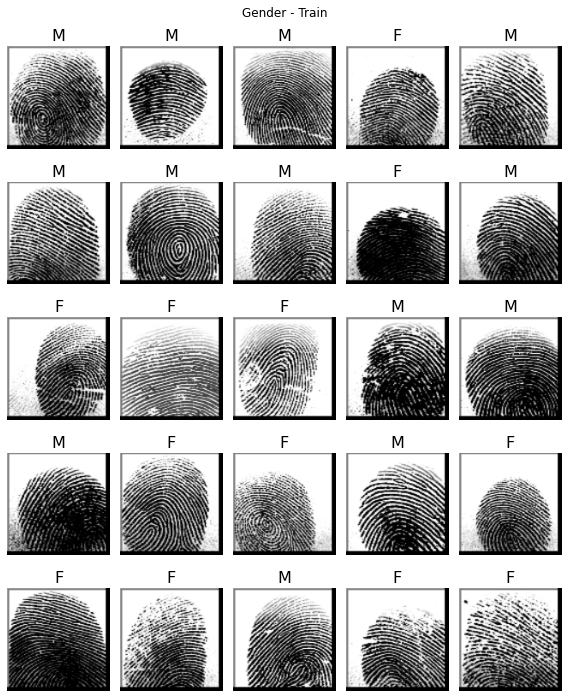

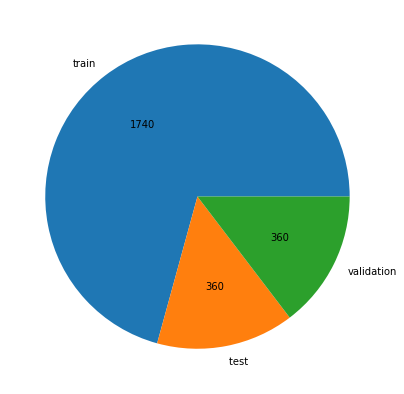

In [5]:
displayDsSamples(genderDS[0], 'Gender - Train', (5, 5), classNames=genderClassNames)
displayDsSplit(genderDS)


In [6]:
train_ds, test_ds, val_ds = genderDS
rn50 = ResNet50(img_dim, weights=weights, trainable=False)
rnc = ResNetClassifier(2, "softmax")
fpml = FPML(rn50, rnc, "", img_dim)
model = fpml.create(Adam, learning_rate, 'binary_crossentropy', 'accuracy')
model_history = model.fit(train_ds, validation_data=val_ds, epochs=10)
test_history = model.evaluate(test_ds)

Epoch 1/10


2022-05-02 20:35:15.709205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - ETA: 0s - loss: 1.0908 - accuracy: 0.6103

2022-05-02 20:35:21.226317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 9s 103ms/step - loss: 1.0908 - accuracy: 0.6103 - val_loss: 0.9707 - val_accuracy: 0.5528
Epoch 2/10
55/55 [==============================] - 4s 70ms/step - loss: 0.7753 - accuracy: 0.6661 - val_loss: 0.8556 - val_accuracy: 0.6056
Epoch 3/10
55/55 [==============================] - 4s 71ms/step - loss: 0.6575 - accuracy: 0.6954 - val_loss: 0.8026 - val_accuracy: 0.6139
Epoch 4/10
55/55 [==============================] - 4s 70ms/step - loss: 0.6183 - accuracy: 0.7126 - val_loss: 0.9870 - val_accuracy: 0.5639
Epoch 5/10
55/55 [==============================] - 4s 71ms/step - loss: 0.5674 - accuracy: 0.7356 - val_loss: 0.8068 - val_accuracy: 0.6083
Epoch 6/10
55/55 [==============================] - 4s 70ms/step - loss: 0.5494 - accuracy: 0.7454 - val_loss: 0.8438 - val_accuracy: 0.6167
Epoch 7/10
55/55 [==============================] - 4s 70ms/step - loss: 0.4980 - accuracy: 0.7851 - val_loss: 0.8266 - val_accuracy: 0.6139
Epoch 8/10
55/55 [=====

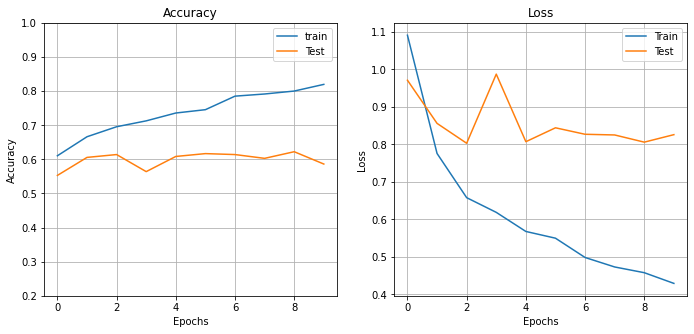

2022-05-02 20:35:59.275080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 20:36:01.436211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


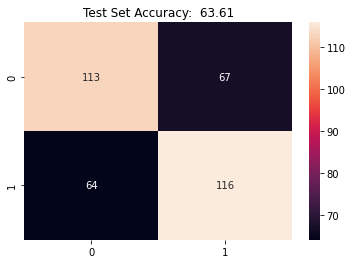

In [7]:
displayTrainProgress(model_history)
test_acc = displayConfusion(test_ds, model)